# <center>UrbanSound8K - Data Augmentation</center>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as transforms

/Users/antoine/Dev/miniconda3/envs/UrbanSound8K/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [207]:
# Dataset class adapted for this particular notebook
class UrbanSound8KDataset(Dataset):
    
    def __init__(self, dataset_path, feature_name, preprocessing_parameters, augmentation=False):
        self.dataset_path = dataset_path
        self.metadata = pd.read_csv(os.path.join(dataset_path, "UrbanSound8K.csv"))
        self.feature_name = feature_name
        self.parameters = preprocessing_parameters
        self.augmentation = augmentation
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        audio_name = self._get_event_audio_name(index)
        class_id = torch.tensor(self._get_event_class_id(index), dtype=torch.long)
        signal, sr = self._get_event_signal(index)
        signal = self._mix_down_if_necessary(signal)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        if self.augmentation:
            signal = self._signal_augmentation(signal)
        if self.feature_name == "spectrogram":
            feature = self._spectrogram_transform(signal)
            if self.augmentation:
                feature = self._feature_augmentation(feature)
            feature = self._db_transform(spectrogram)
        elif self.feature_name == "mel-spectrogram":
            feature = self._mel_spectrogram_transform(signal)
            if self.augmentation:
                feature = self._feature_augmentation(feature)
            feature = self._db_transform(feature)
        elif self.feature_name == "mfcc":
            feature = self._mfcc_transform(signal)
            if self.augmentation:
                feature = self._feature_augmentation(feature)            
        return index, audio_name, class_id, signal, feature
    
    def _get_event_class_id(self, index):
        return self.metadata.iloc[index]["classID"]
    
    def _get_event_audio_name(self, index):
        return self.metadata.iloc[index]["slice_file_name"]
    
    def _get_event_signal(self, index):
        event_fold = f"fold{self.metadata.iloc[index]['fold']}"
        event_filename = self.metadata.iloc[index]["slice_file_name"]
        audio_path = os.path.join(self.dataset_path, event_fold, event_filename)
        signal, sr = torchaudio.load(audio_path, normalize=True)
        return signal, sr
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _resample_if_necessary(self, signal, sr):
        if sr != self.parameters["target_sample_rate"]:
            resample_transform = transforms.Resample(sr, self.parameters["target_sample_rate"])
            signal = resample_transform(signal)
        return signal
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.parameters["n_samples"]:
            signal = signal[:, :self.parameters["n_samples"]]
        return signal
        
    def _right_pad_if_necessary(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.parameters["n_samples"]:
            num_missing_samples = self.parameters["n_samples"] - signal_length
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _signal_augmentation(self, signal):
        return signal
    
    def _spectrogram_transform(self, signal):
        spectrogram_transform = transforms.Spectrogram(
                                                        n_fft = self.parameters["n_fft"],
                                                        win_length = self.parameters["n_fft"],
                                                        hop_length = self.parameters["n_fft"] // self.parameters["hop_denominator"],
                                                        pad = 0,
                                                        window_fn = torch.hann_window,
                                                        power = 2,
                                                        normalized = True,
                                                        wkwargs = None,
                                                        center = False,
                                                        pad_mode = "reflect",
                                                        onesided = True,
                                                        return_complex = False
                                                        )  
        spectrogram = spectrogram_transform(signal)
        return spectrogram
    
    def _mel_spectrogram_transform(self, signal):
        mel_spectrogram_transform = transforms.MelSpectrogram(
                                                        sample_rate = self.parameters["target_sample_rate"],
                                                        n_fft = self.parameters["n_fft"],
                                                        n_mels = self.parameters["n_mels"],
                                                        window_fn = torch.hann_window,
                                                        power = 2,
                                                        normalized = True,
                                                        wkwargs = None,
                                                        center = True,
                                                        pad_mode = "reflect",
                                                        onesided = True,
                                                        norm = None,
                                                        mel_scale = "htk"
                                                        )
        mel_spectrogram = mel_spectrogram_transform(signal)
        return mel_spectrogram

    def _mfcc_transform(self, signal):
        mfcc_transform = transforms.MFCC(
                                        sample_rate = self.parameters["target_sample_rate"],
                                        n_mfcc = self.parameters["n_mfcc"],
                                        dct_type = 2,
                                        norm = "ortho",
                                        log_mels = False 
                                        )
        mfcc = mfcc_transform(signal)
        return mfcc
    
    def _db_transform(self, spectrogram):
        db_transform = transforms.AmplitudeToDB(stype="power")
        spectrogram_db = db_transform(spectrogram)
        return spectrogram_db

    def _feature_augmentation(self, feature):
        frequency_masking = transforms.FrequencyMasking(freq_mask_param=10)
        time_masking = transforms.TimeMasking(time_mask_param=80, p=1.0)
        feature = frequency_masking(feature)
        feature = time_masking(feature)
        return feature

In [208]:
# Audio pre-processing parameters
target_sample_rate = 22050
target_length = 4
n_samples = target_length * target_sample_rate

spectrogram_parameters = {
                    "target_sample_rate": target_sample_rate,
                    "target_length": target_length,
                    "n_samples": n_samples,
                    "n_fft": 512,
                    "hop_denominator": 2,
}

melspectrogram_parameters = {
                    "target_sample_rate": target_sample_rate,
                    "target_length": target_length,
                    "n_samples": n_samples,
                    "n_fft": 512,
                    "hop_denominator": 2,
                    "n_mels": 64, 
}

mfcc_parameters = {
                    "target_sample_rate": target_sample_rate,
                    "target_length": target_length,
                    "n_samples": n_samples,
                    "n_mfcc": 40      
}

In [209]:
feature = "mel-spectrogram"

if feature == "spectrogram":
    preprocessing_parameters = spectrogram_parameters
elif feature == "mel-spectrogram":
    preprocessing_parameters = melspectrogram_parameters
elif feature == "mfcc":
    preprocessing_parameters = mfcc_parameters

In [210]:
ds = UrbanSound8KDataset(
                        dataset_path="../dataset", 
                        feature_name=feature,
                        preprocessing_parameters=preprocessing_parameters,
                        augmentation=True
                        )

In [211]:
event_idx = ds.metadata[ds.metadata["slice_file_name"]=="7061-6-0-0.wav"].index.item()

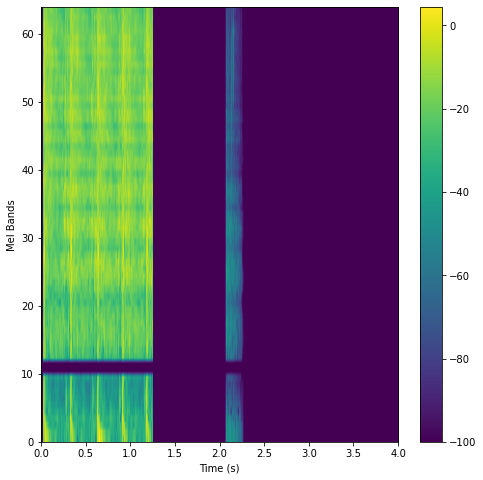

In [213]:
fig, ax = plt.subplots(figsize=(8,8))

if feature == "spectrogram":
    pos = ax.imshow(torch.squeeze(ds[event_idx][4]), extent=[0, target_length, 0, target_sample_rate/2], origin="lower", aspect="auto", cmap="viridis")
    ax.set_ylabel("Frequency (Hz)")
elif feature == "mel-spectrogram":
    pos = ax.imshow(torch.squeeze(ds[event_idx][4]), extent=[0, target_length, 0, melspectrogram_parameters["n_mels"]], origin="lower", aspect="auto", cmap="viridis")
    ax.set_ylabel("Mel Bands")
elif feature == "mfcc":
    pos = ax.imshow(torch.squeeze(ds[event_idx][4]), extent=[0, target_length, 0, mfcc_parameters["n_mfcc"]], origin="lower", aspect="auto", cmap="viridis")
    ax.set_ylabel("MFCC")  
    
ax.set_xlabel("Time (s)")

fig.colorbar(pos, ax=ax)

plt.show()

In [180]:
print(f"Feature max value: {round(ds[event_idx][4].max().item(), 1)}")
print(f"Feature min value: {round(ds[event_idx][4].min().item(), 1)}")

Feature max value: 4.4
Feature min value: -100.0


Shape of waveform: torch.Size([2, 99225])
Sample rate of waveform: 44100


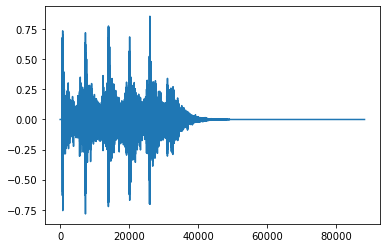

In [214]:
waveform, sample_rate = torchaudio.load("../dataset/fold1/7061-6-0-0.wav", normalize=True)
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(ds[event_idx][3].t().numpy())
plt.show()